In [206]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import ml_collections as mlc
import torch
from torch.autograd.functional import jacobian
import seaborn as sns

from Empirical.data import getLogRet
from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder, train, MaskedMSELoss
import BasicAutoEncoder
from BasicAutoEncoder.util import plot_factor_estimates, plot_train_hist, plot_reconstructed_y, get_trainable_params
from mcmc.ErrorProcess import IIDErrorProcess, ArErrorProcess
from mcmc.mcmc import trainMCMC, trainMCMCMasked
from BasicAutoEncoder.Metric import CCACorr

from Andreini_data.data import load_y

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(601, 116)


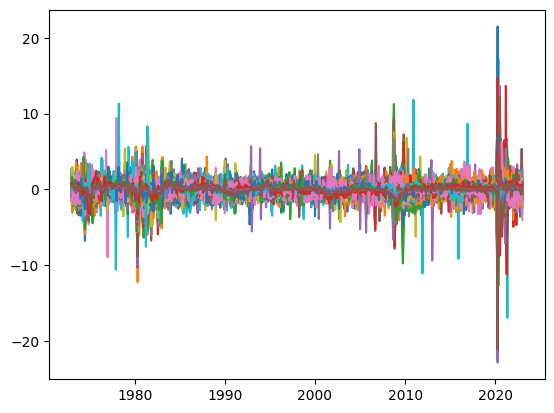

In [207]:

y, mask, index= load_y()
y[np.isnan(y)] = 0
print(y.shape)
plt.plot(index,y);

(300, 116) (100, 116) (201, 116)


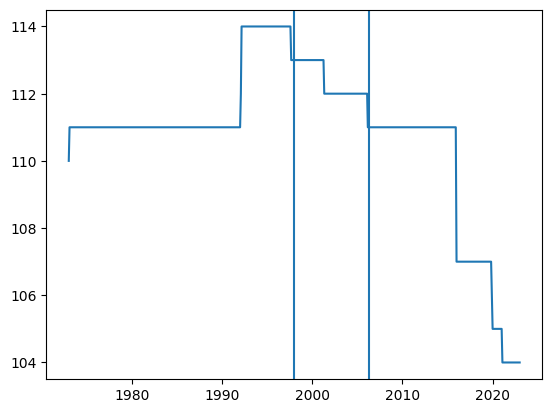

In [241]:
cfg = mlc.ConfigDict()
cfg.factor_dim = 5
cfg.obs_dim = y.shape[1]
cfg.p_factor = 2
cfg.p_eps = 0
cfg.T_train = 300
cfg.T_test = 129
cfg.T_val = 100
cfg.T = y.shape[0] #529

#Training config
cfg.batch_size = 32
cfg.lr = 0.0001
cfg.n_epoch = 10
cfg.max_iter = 25


#Create train test val
y_train = y[0:cfg.T_train]
y_val = y[cfg.T_train:cfg.T_train+cfg.T_val]
y_test = y[cfg.T_train+cfg.T_val:]

weights_train = mask[0:cfg.T_train]
weights_val = mask[cfg.T_train:cfg.T_train+cfg.T_val]
print(y_train.shape, y_val.shape, y_test.shape)


plt.plot(index,mask.sum(axis=1))
plt.axvline(x=index[cfg.T_train])
plt.axvline(x=index[cfg.T_train+cfg.T_val])

In [250]:

cfg.lr = 0.001
cfg.obs_dim = y_train.shape[1]
dec = Decoder(hidden_dim=[cfg.factor_dim, cfg.obs_dim], activation=nn.Tanh(), lastLayerLinear=True)
enc = Encoder(hidden_dim=[cfg.obs_dim, 50, cfg.factor_dim], activation=nn.Tanh(), lastLayerLinear=False)
mod = AutoEncoder(enc=enc, dec=dec)
print(f"Number of trainable paramaters {get_trainable_params(mod)}")
errorProcess = IIDErrorProcess(n=cfg.obs_dim, T = cfg.T)
#errorProcess = ArErrorProcess(n=cfg.obs_dim, T = cfg.T, d=5)
metrics = []
train_hist = trainMCMCMasked(X_train=y_train, X_val = y_val, weights_train=weights_train, weights_val=weights_val, model=mod, errorProcess = errorProcess, n_epoch=cfg.n_epoch, lr = cfg.lr, batch_size=cfg.batch_size, metrics=metrics, max_iter=cfg.max_iter)
print(f"Training loss: {train_hist['train_loss'][-1]}, Validation Loss: {train_hist['val_loss'][-1]}")

/Users/julianvanmeggelen/Documents/Studie/2022:23/Thesis/Empirical/../BasicAutoEncoder/model.py:54: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(res[f"linear_{i}"].weight)


Number of trainable paramaters 6801
torch.Size([300, 116]) torch.Size([100, 116])
1 1.686594581604004816040042
2 1.243187654018402140184021
3 1.097845268249511782495117
4 0.975851112604141326041413
5 0.946110707521438675214386
6 0.893665581941604619416046
7 0.828291708230972382309723
8 0.829637980461120604611206
9 0.795349782705307827053073
10 0.76832396388053898805389
11 0.78036573529243472924347
12 0.71861190795898439589843
13 0.71825957894325259432525
14 0.71470553874969487496948
15 0.71352902054786685478668
16 0.72215694189071668907166
17 0.69514743089675908967595
18 0.66704562306404110640411
19 0.70159465074539187453918
20 0.68731665611267091126709
21 0.68181984424591072459107
22 0.68627837896347049634704
23 0.67930638790130629013062
24 0.68995074033737183373718
25 0.65170716643333444333344
26 0.66609684228897092889709
Training loss: 0.6660968422889709, Validation Loss: 0.35274747014045715


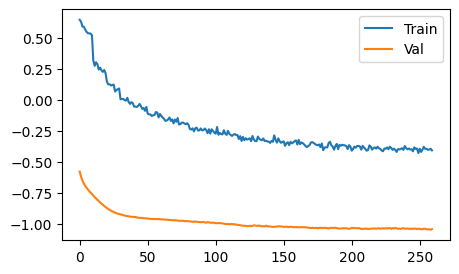

In [251]:
plot_train_hist(train_hist=train_hist)

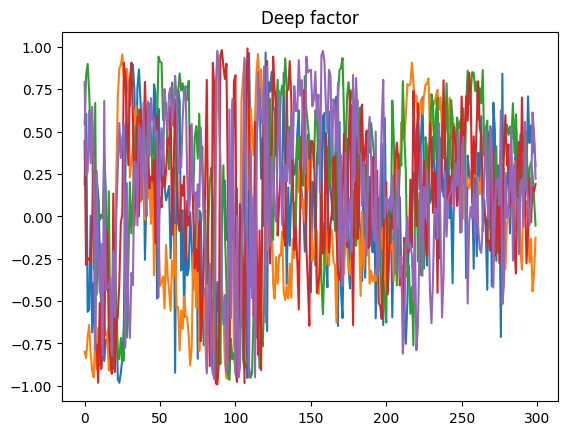

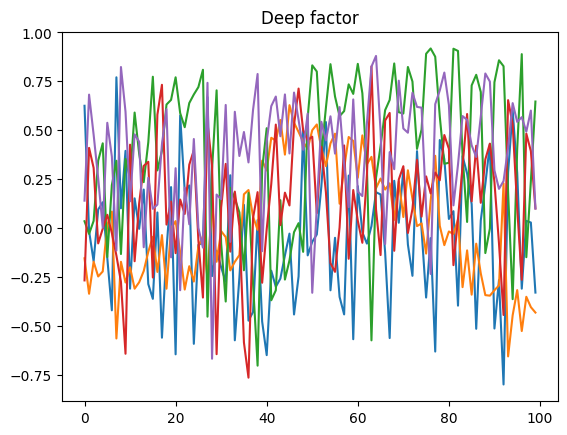

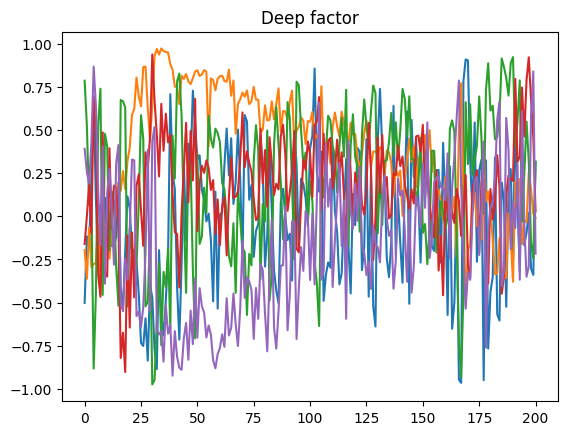

In [252]:
plot_factor_estimates(mod, y_train)
plt.figure();
plot_factor_estimates(mod, y_val)
plt.figure();
plot_factor_estimates(mod, y_test)

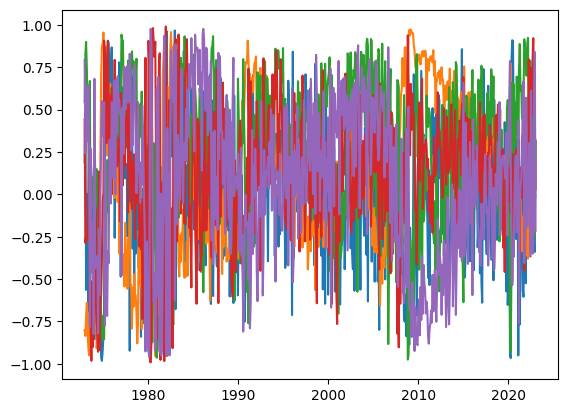

In [253]:
f_hat = mod.enc(torch.Tensor(y).float()).detach().numpy()
plt.plot(index, f_hat);

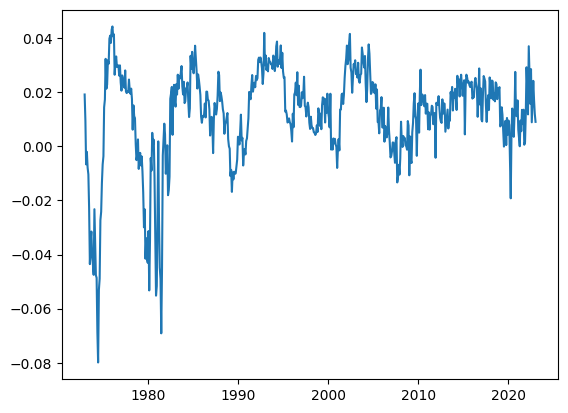

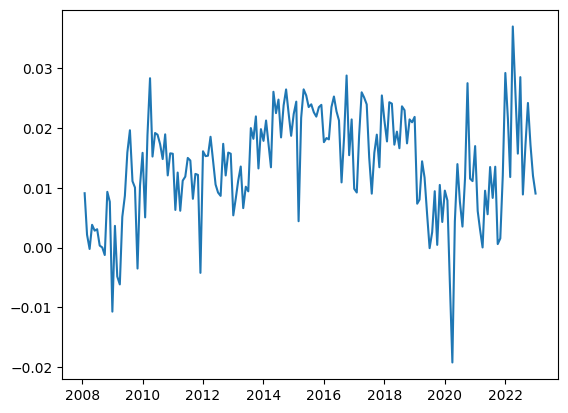

In [254]:
def fobreniusNorm(F):
    return np.sum(F**2)

def computeCI(F, f):
    res = []
    sum = 0
    fn = fobreniusNorm(F)
    for k in range(f.shape[1]):
        for i in range(F.shape[1]):
            sum += f[:,k] * (F[k,i]**2)/fn
    return sum

F = mod.enc.sequential[0].weight.detach().numpy()
CI = computeCI(F, f_hat)

plt.plot(index,CI)
plt.figure()
i = np.argwhere(index > '2008').min()
plt.plot(index[i:],CI[i:])

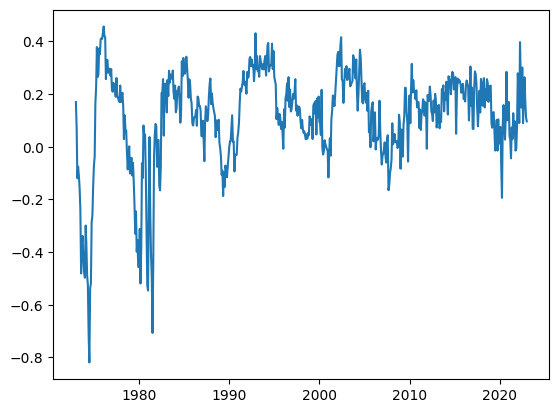

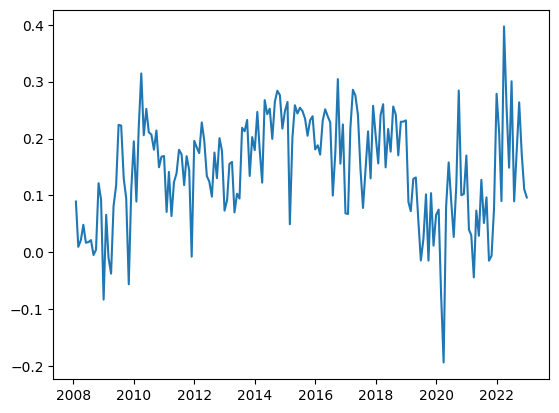

In [255]:
def fobreniusNorm(F):
    return np.sum(F**2)

def computeCI(F, f):
    res = []
    for t in range(f.shape[0]):
        
        jac = jacobian(mod.dec, torch.Tensor(f[t]).float()).detach().numpy().T
        sum = 0
        fn = fobreniusNorm(jac)
        for k in range(f.shape[1]):
            for i in range(F.shape[1]):
                sum += f[t,k] * (jac[k,i]**2)/fn
        res.append(sum)
    return res

F = mod.enc.sequential[0].weight.detach().numpy()
CI = computeCI(F, f_hat)

plt.plot(index,CI)
plt.figure()
i = np.argwhere(index > '2008').min()
plt.plot(index[i:],CI[i:])


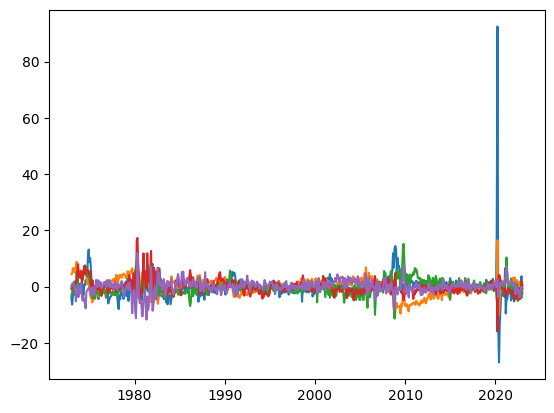

In [256]:
from sklearn.decomposition import PCA
pca = PCA(n_components=cfg.factor_dim)
f_hat_rotated = pca.fit_transform(y)
plt.plot(index,f_hat_rotated);

## Cast in statespace with EKF

In [257]:
from statsmodels.tsa.vector_ar.var_model import VAR
f_train_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
f_val_hat = mod.enc(torch.Tensor(y_val).float()).detach().numpy()
varModel = VAR(np.concatenate([f_train_hat, f_val_hat]))
res = varModel.fit(maxlags=1, ic='aic')
y_hat = mod(torch.Tensor(y).float()).detach().numpy()
resid = y - y_hat
obs_cov = np.cov(resid.T)

<Axes: >

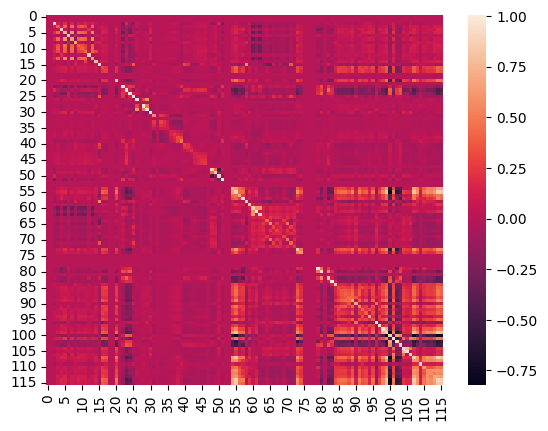

In [217]:
sns.heatmap(obs_cov)

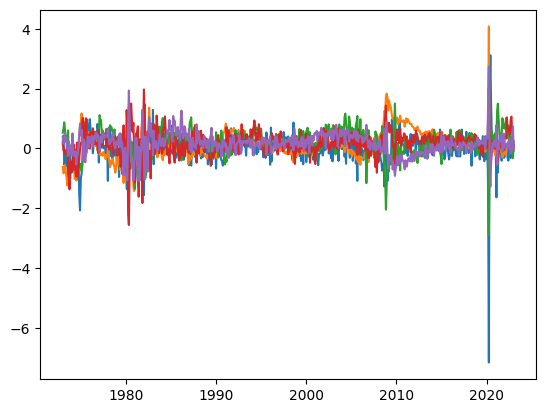

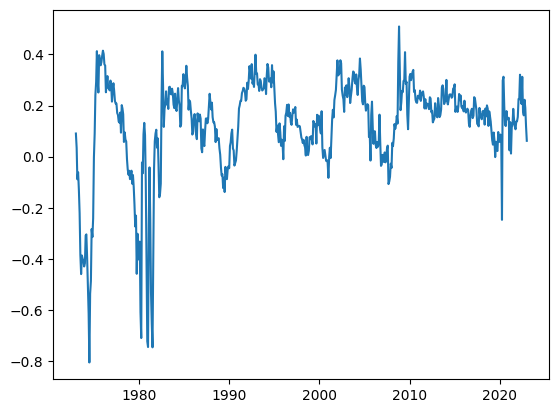

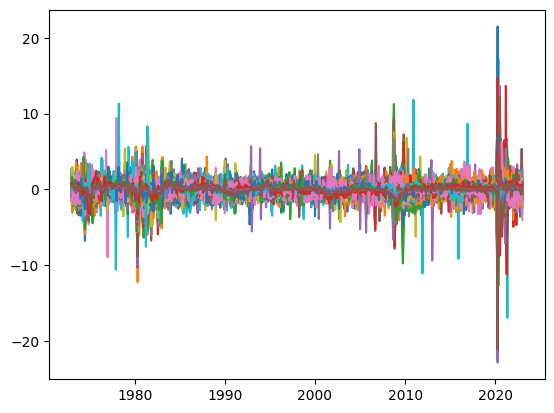

In [258]:
from filterpy.kalman import ExtendedKalmanFilter as ExtendedKalmanFilter
dim_x = cfg.factor_dim
dim_z = cfg.obs_dim
ekf = ExtendedKalmanFilter(dim_x, dim_z)
ekf.R = np.diag(np.diag(obs_cov))
#ekf.Q = res.sigma_u
ekf.F = res.params[:-1]
ekf.P = res.sigma_u
ekf.x = f_train_hat[-1]
decoder = mod.dec
Hx = lambda state: decoder(torch.Tensor(state).float()).detach().numpy()
HJacobian = lambda state: jacobian(decoder,torch.Tensor(state).float()).detach().numpy()
xs = []
zs = []
for i in range(y.shape[0]):
    z = y[i,:]
    ekf.update(z, HJacobian, Hx)
    xs.append(ekf.x)
    ekf.predict()
    zs.append(ekf.z)
plt.plot(index, np.stack(xs));
plt.figure()
plt.plot(index, computeCI(F, np.stack(xs)))
plt.figure()
plt.plot(index, np.stack(zs));
